In [ ]:
# Import des packages 
import pandas as pd
import numpy as np
import sklearn
from scipy import sparse

# Insérez votre code ici
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold   
from sklearn.model_selection import 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



In [ ]:
# On importe le dataset complet mais reduit en 100*100

df = pd.read_csv("radio_tab.csv")


In [4]:
# On cree un jeu de données réduit en respectant les proportions initiales 

df.rename(columns = {'Unnamed: 0':'FILENAME'}, inplace = True)

df = df.set_index("FILENAME")

#df = df.rename(columns = {'Unnamed : 0' : 'FILENAME'})
df.head()

,FORMAT,SIZE,URL,TYPE,num,0,1,2,3,4,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
FILENAME,,,,,,,,,,,,,,,,,,,,,
Lung_Opacity-1,PNG,256*256,rnsa,Lung_Opacity,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-2,PNG,256*256,rnsa,Lung_Opacity,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-3,PNG,256*256,rnsa,Lung_Opacity,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-4,PNG,256*256,rnsa,Lung_Opacity,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-5,PNG,256*256,rnsa,Lung_Opacity,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# On fait un X et Y 
# # On convertit en entier pour économiser en mémoire

X = df.iloc[:,5:].astype("int")

target = df["URL"] + "_"  + df["TYPE"]

type = df["TYPE"]

source = df["URL"]

X.head()



,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
FILENAME,,,,,,,,,,,,,,,,,,,,,
Lung_Opacity-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lung_Opacity-5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X.dtypes
X.shape

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, type, stratify=target, test_size=0.3, random_state=42)

# On fait une ACP
## Pourcentage de variance expliquée par les axes


In [14]:

pca = PCA(n_components=0.95)

pca.fit(X_train)

data_2D = pca.fit_transform(X_train)

import seaborn as sns 

# Avec les 10 premières composantes 

print("Avec les 10 premieres composantes, on explique : ", pca.explained_variance_ratio_[:11].sum().round(3) * 100 , " % de la variabilité")


print("Pour avoir 95 pour cent  de la variabilité initiale il faut : ", pca.explained_variance_ratio_.shape[0], "composantes")

Avec les 10 premieres composantes, on explique :  54.0  % de la variabilité
Pour avoir 95 pour cent  de la variabilité initiale il faut :  782 composantes


Text(0.5, 1.0, "Pourcentage de variance expliquée par les 10 premiers axes de l'ACP")

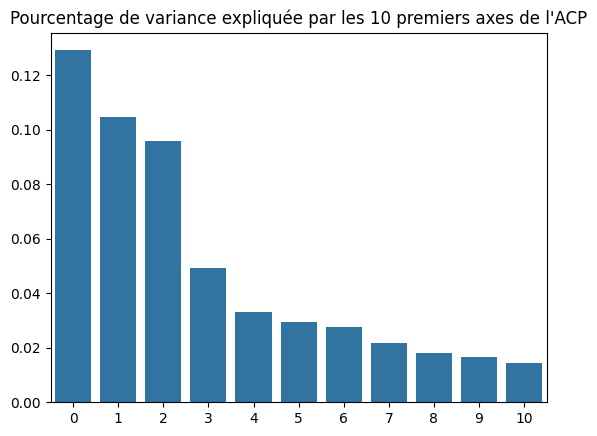

In [ ]:
# Histogramme des parts de variance de l'ACP

sns.barplot(pca.explained_variance_ratio_[:11])
plt.title("Pourcentage de variance expliquée par les 10 premiers axes de l'ACP")


Text(0.5, 1.0, "Pourcentage de variance cumulée expliquée par les 20 premiers axes de l'ACP")

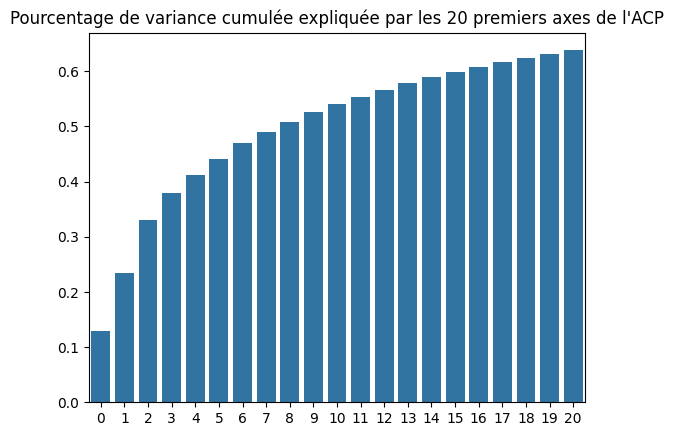

In [ ]:
# Idem en variance cumulée
sns.barplot(pca.explained_variance_ratio_.cumsum()[:21])
plt.title("Pourcentage de variance cumulée expliquée par les 20 premiers axes de l'ACP")


## Projection sur les axes 1 et 2 de l'ACP

In [ ]:
# On retrouve l'information source
X_train.head()
url = df["URL"]

source_train = X_train.iloc[:,1:2].merge(url, how="left", left_index = True, right_index = True).reset_index

source = source_train["URL"]

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


La part de variance expliquée est 0.95


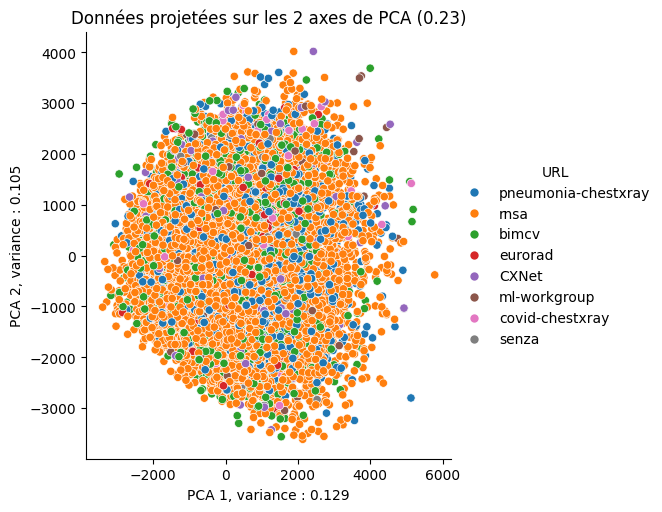

In [103]:
# On visualise la source sur les deux premiers axes de l'ACP
sns.relplot(x=data_2D[:, 0], y=data_2D[:, 1], hue = source, cmap=plt.cm.Spectral)

print("La part de variance expliquée est", round(pca.explained_variance_ratio_.sum(),2))

abcisse = 'PCA 1, variance : ' +  str(pca.explained_variance_ratio_[0].round(3))
ordonnées = 'PCA 2, variance : ' +  str(pca.explained_variance_ratio_[1].round(3))
plt.xlabel(abcisse)
plt.ylabel(ordonnées)

plt.title("Données projetées sur les 2 axes de PCA" + " (" + str(round(pca.explained_variance_ratio_[:2].sum(),2)) +")")
plt.show();

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


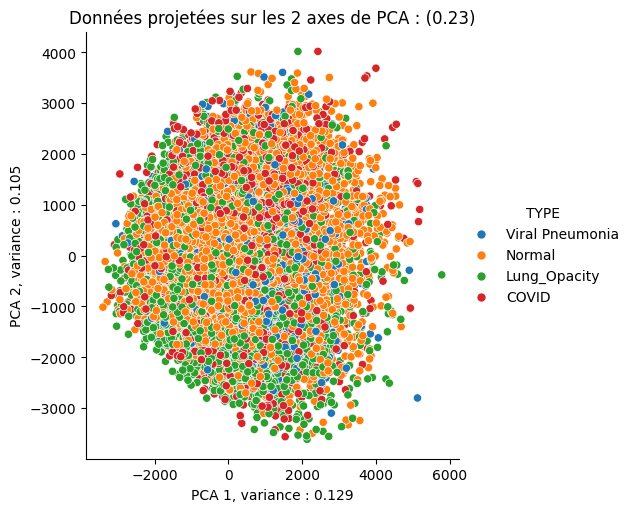

In [ ]:
# On visualise la catégorie sur les deux premiers axes de l'ACP
type = y_train

sns.relplot(x=data_2D[:, 0], y=data_2D[:, 1], hue = type, cmap=plt.cm.Spectral)

abcisse = 'PCA 1, variance : ' +  str(pca.explained_variance_ratio_[0].round(3))
ordonnées = 'PCA 2, variance : ' +  str(pca.explained_variance_ratio_[1].round(3))
plt.xlabel(abcisse)
plt.ylabel(ordonnées)

plt.title("Données projetées sur les 2 axes de PCA : (" + str(round(pca.explained_variance_ratio_[:2].sum(),2)) +")")
plt.show();

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


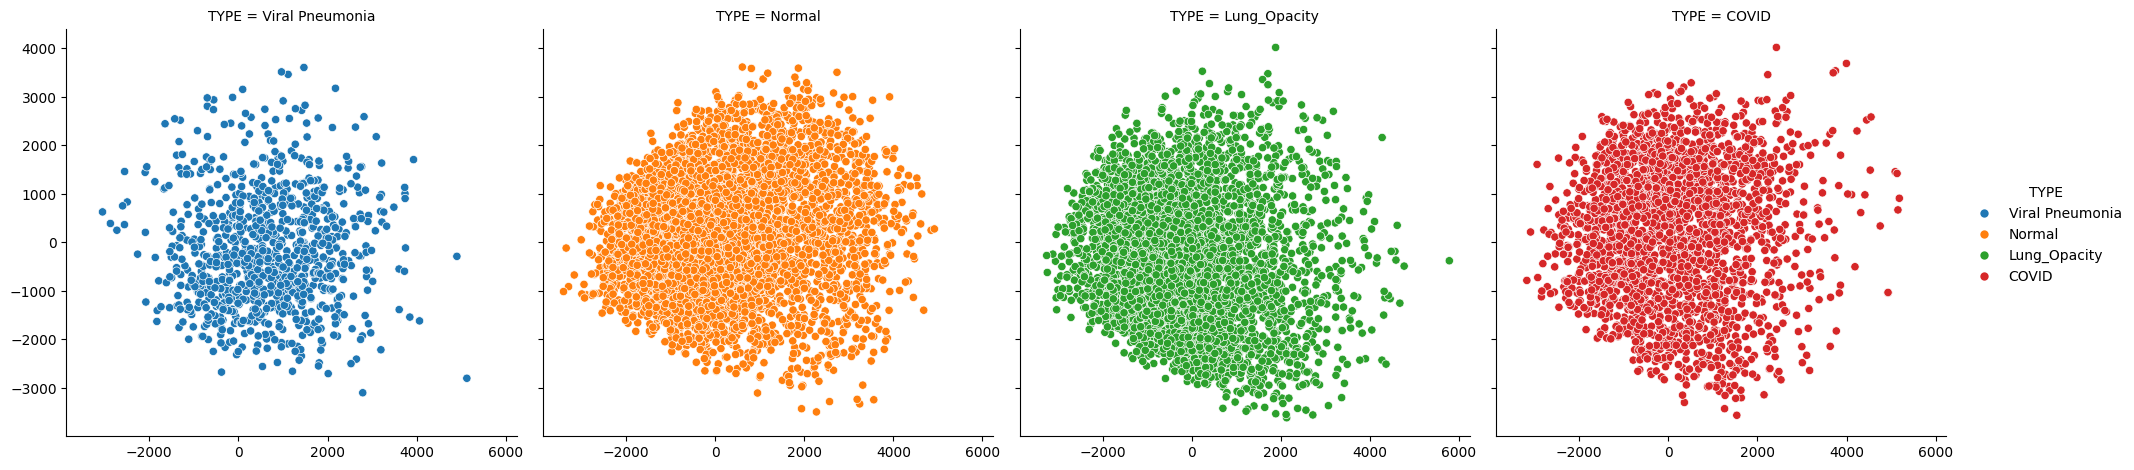

In [ ]:
# On fait un graph par catégorie pour y voir plus clair

sns.relplot(x=data_2D[:, 0], y=data_2D[:, 1], hue = type, cmap=plt.cm.Spectral, col=type)

plt.show();

## Projection sur les axes 3 et 4 de l'ACP

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


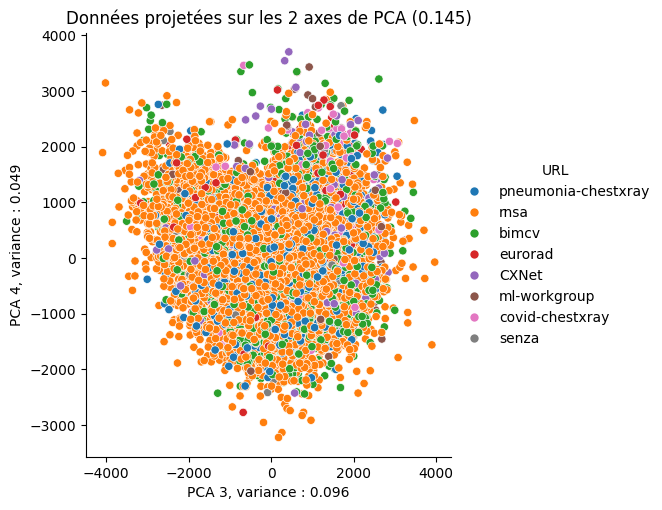

In [104]:
# Visualisation de l'information source sur les axes 3 et 4
sns.relplot(x=data_2D[:, 2], y=data_2D[:, 3], hue = source, cmap=plt.cm.Spectral)

abcisse = 'PCA 3, variance : ' +  str(pca.explained_variance_ratio_[2].round(3))
ordonnées = 'PCA 4, variance : ' +  str(pca.explained_variance_ratio_[3].round(3))
plt.xlabel(abcisse)
plt.ylabel(ordonnées)

plt.title("Données projetées sur les 2 axes de PCA" + " (" + str((pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]).round(3)) +")")
plt.show();

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


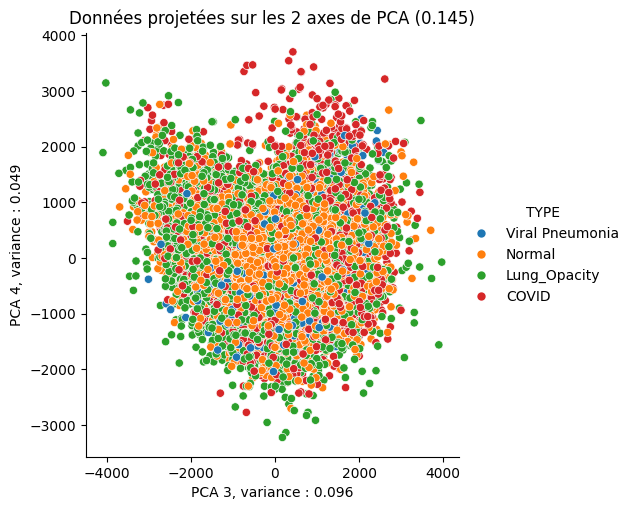

In [ ]:
# Visualiation des catégories sur les axes 3 et 4
sns.relplot(x=data_2D[:, 2], y=data_2D[:, 3], hue = type, cmap=plt.cm.Spectral)

abcisse = 'PCA 3, variance : ' +  str(pca.explained_variance_ratio_[2].round(3))
ordonnées = 'PCA 4, variance : ' +  str(pca.explained_variance_ratio_[3].round(3))
plt.xlabel(abcisse)
plt.ylabel(ordonnées)

plt.title("Données projetées sur les 2 axes de PCA" + " (" + str((pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]).round(3)) +")")
plt.show();

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\seaborn\relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


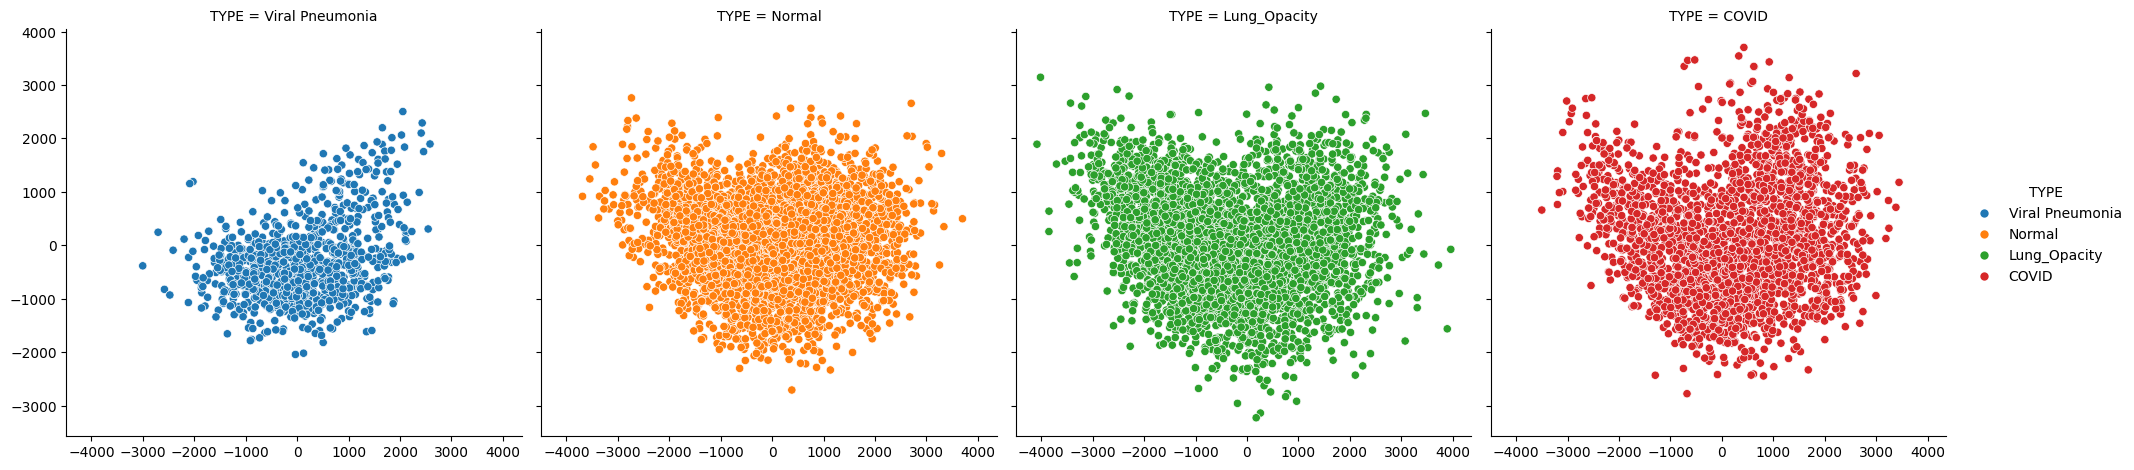

In [ ]:
# On fait un graphique par type pour mieux voir
sns.relplot(x=data_2D[:, 2], y=data_2D[:, 3], hue = type, cmap=plt.cm.Spectral, col=type)

plt.show();

## Visualisation des composantes

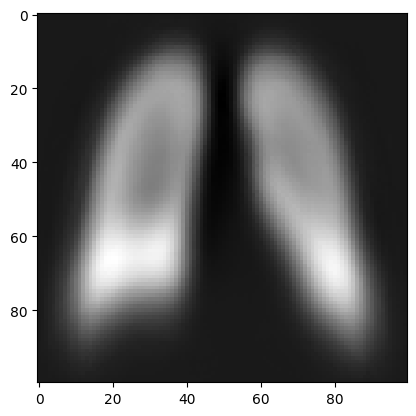

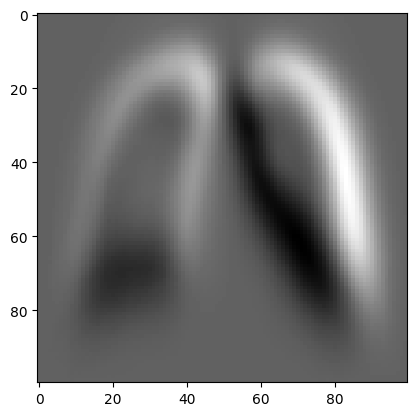

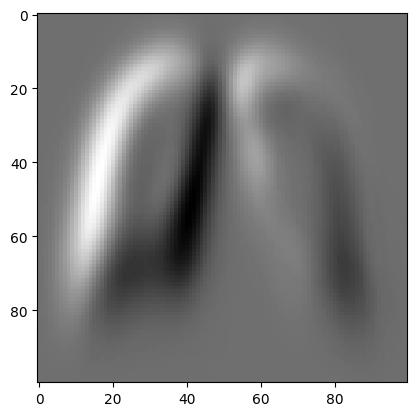

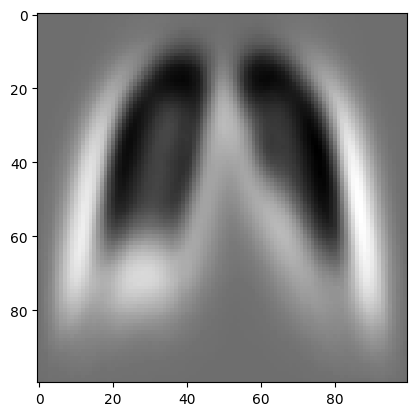

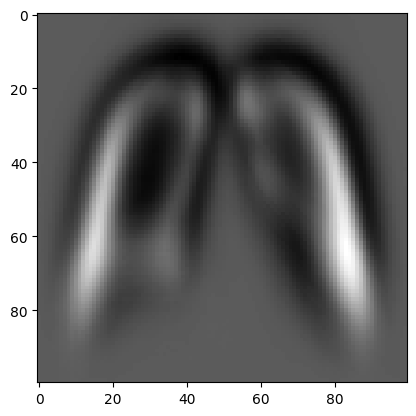

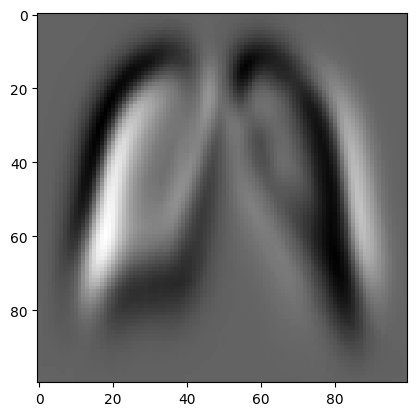

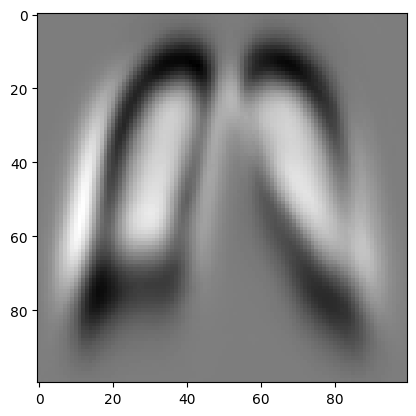

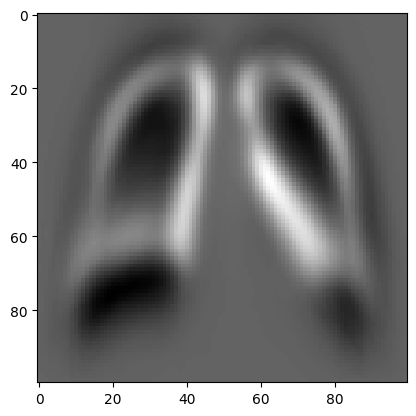

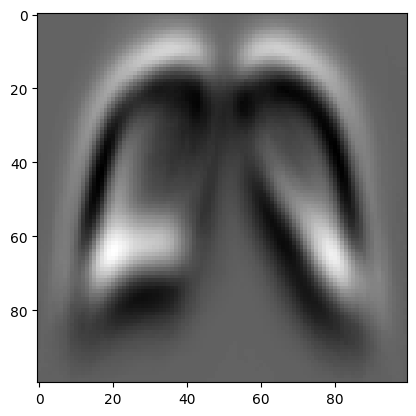

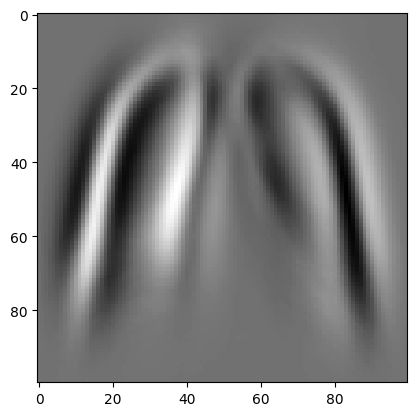

In [79]:
# On visualise les 4 premières composantes de l'ACP

for i in range(10):
    plt.figure()
    plt.imshow(pca.components_[i].reshape(100,100), cmap = 'gray')


## Test d'un modèle de Random Forest à partir des résultats de l'ACP

In [ ]:
# Trasformation des jeux de données

X_train_pca = pca.transform(X_train)

X_test_pca = pca.transform(X_test)

### Création d'un premier modèle

In [ ]:
# Application d'un premier modèle de Forêt aléatoire
from sklearn.ensemble import RandomForestClassifier

# On separe apprentissage et validation

rf = RandomForestClassifier()

rf.fit(X_train_pca, y_train)

# A voir en ajustant les parametres

y_pred = rf.predict(X_test_pca)

#rf.score(y_test, y_pred)



In [32]:
print(sklearn.metrics.classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

          COVID       0.79      0.17      0.28      1085
   Lung_Opacity       0.56      0.54      0.55      1804
         Normal       0.63      0.89      0.74      3057
Viral Pneumonia       1.00      0.15      0.26       404

       accuracy                           0.62      6350
      macro avg       0.75      0.44      0.46      6350
   weighted avg       0.66      0.62      0.58      6350



### Optimisation du modèle

In [35]:
# On cherche à optimiser les paramètres de la foret aléatoire

params = {
# Number of trees in random forest
"n_estimators" : [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

crossval = KFold(n_splits = 3, random_state = 42, shuffle = True)

grid = GridSearchCV(estimator = rf, param_grid = params, cv=crossval, scoring = 'f1_macro')
grid.fit(X_train, y_train)
print(grid.best_params_)


# alpha_grid = {'alpha':[1/i for i in range(1,10)]}
# grid = GridSearchCV(estimator = lasso, param_grid = alpha_grid, cv=crossval, scoring = 'neg_mean_squared_error')
# grid.fit(X_train, y_train)
# print(grid.best_params_)


{'n_estimators': 900}


### Performances du nouveau modèle

In [36]:
# On reapplique le meilleur  de rf
rf = RandomForestClassifier(n_estimators = 900)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [37]:
print(sklearn.metrics.classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

          COVID       0.80      0.33      0.47      1085
   Lung_Opacity       0.72      0.79      0.75      1804
         Normal       0.77      0.92      0.84      3057
Viral Pneumonia       0.97      0.66      0.78       404

       accuracy                           0.76      6350
      macro avg       0.81      0.67      0.71      6350
   weighted avg       0.77      0.76      0.75      6350



In [ ]:
# Matrice de confusion

cm = confusionmatrix(y_test, y_pred, labels=clf.classes)
disp = ConfusionMatrixDisplay(confusionmatrix=cm, display_labels=clf.classes)
disp.plot(cmap="blues")

## Test de sélection des variables les plus pertinentes

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    0     1     2 ... 89398 89399 89400] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Text(0.5, 1.0, 'Masque en conservant les 90% de variables les plus importantes')

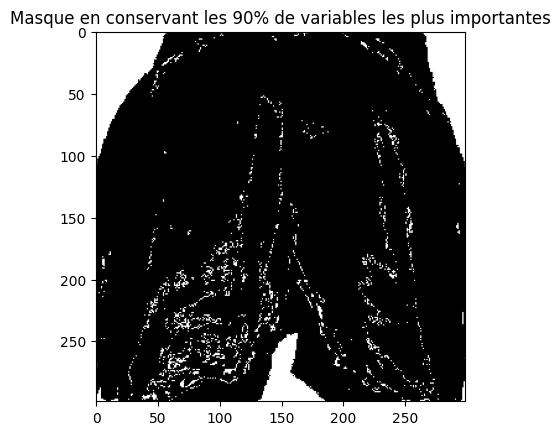

In [179]:
# On regarde si certaines zones sont plus variable que d'autre sur les images
# Ce n est pas applicable a du multilabel, on comparera juste COVID ou non

from sklearn.feature_selection import SelectPercentile

cible = np.where(type=="COVID",1,0)


# # On utilise variance threshold pour supprimer les variables qui ne varient pas 

# from sklearn.feature_selection import VarianceThreshold

# sel = VarianceThreshold(threshold=1e-6)

# X2 = sel.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, cible, test_size = .2, random_state = 84, shuffle = True)

sel = SelectPercentile(percentile = 90)
sel.fit(X_train, y_train)

plt.imshow(sel.get_support().reshape(299,299), cmap = 'gray_r');

plt.title("Masque en conservant les 90% de variables les plus importantes")

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    0     1     2 ... 89398 89399 89400] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


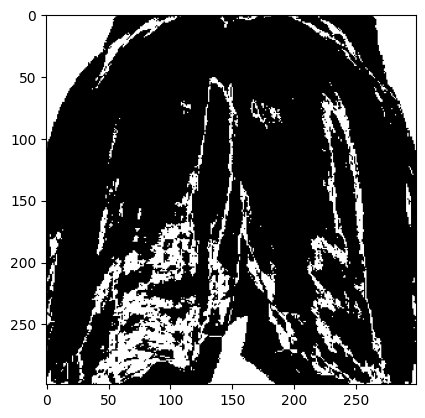

In [177]:

sel = SelectPercentile(percentile = 80)
sel.fit(X_train, y_train)

plt.imshow(sel.get_support().reshape(299,299), cmap = 'gray_r');

plt.title("Masque en conservant les 80% de variables les plus importantes")

c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [    0     1     2 ... 89398 89399 89400] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Inrae\anaconda3\envs\RadioPulmonaire\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


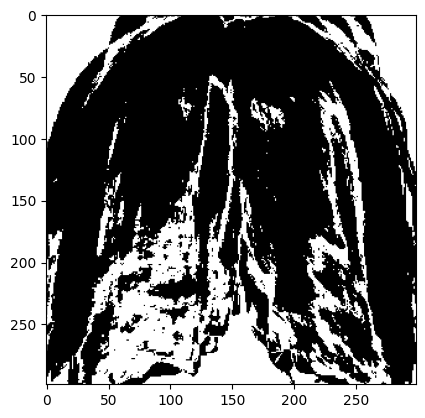

In [178]:
sel = SelectPercentile(percentile = 70)
sel.fit(X_train, y_train)

plt.imshow(sel.get_support().reshape(299,299), cmap = 'gray_r');
plt.title("Masque en conservant les 70% de variables les plus importantes")